# Triplet Loss in Fast.ai
Let's try to get basic triplet loss working with Fast.ai library

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [18]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
import csv
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

import torchvision.transforms as transforms

import pandas as pd

from torch.utils.data import DataLoader,Dataset

Setup constants for image paths

In [5]:
PATH = Path('/home/ubuntu/data/whale-categorization-playground')
IMG_PATH = PATH/"cropped-train"
list(IMG_PATH.iterdir())[:5]

[PosixPath('/home/ubuntu/data/whale-categorization-playground/cropped-train/beba228a.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/cropped-train/6c5ad43e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/cropped-train/974961a4.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/cropped-train/d9f3391e.jpg'),
 PosixPath('/home/ubuntu/data/whale-categorization-playground/cropped-train/f1ca32dc.jpg')]

Let's define functions needed for image display/manipulation

In [25]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def imshow(img, text=None, should_save=False):     #数据集出图
    npimg = img.numpy()   #转numpy
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                bbox={'facecolor':'white','alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

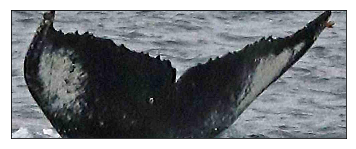

In [7]:
test_image = list(IMG_PATH.iterdir())[:5][1]
im = open_image(test_image)
show_img(im)

In [8]:
def  pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [9]:
def MiniBatchAllTriplets(data_path, batch_path, num_class, num_pic):
    name_list = os.listdir(data_path)
    batch_name = random.sample(name_list, num_class)
    batch_name.sort()
    print(batch_name)
    batch_apn = []
    for k in range(len(batch_name)):
        name = batch_name[k]
        path1 = data_path + name + '/'
        pic_list1 = os.listdir(path1)
        batch_pic1 = random.sample(pic_list1, num_pic)
        batch_pic1.sort()                       #sort pics in the batch
        for i in range(len(batch_pic1)):
            anchor_pic = batch_pic1[i]
            anchor_pic = path1 + anchor_pic
            for j in range(len(batch_pic1)):
                if i!= j:
                    positive_pic = batch_pic1[j]
                    positive_pic = path1 + positive_pic
                    pic_ap = anchor_pic + '\t' + positive_pic    #make ap pairs per pic
                    for v in range(len(batch_name)):
                        name_other = batch_name[v]
                        path2 = data_path + name_other + '/'
                        pic_list2 = os.listdir(path2)
                        batch_pic2 = random.sample(pic_list2, num_pic)
                        batch_pic2.sort()
                        if v != k:
                            for q in range(len(batch_pic2)):
                                negative_pic = batch_pic2[q]
                                negative_pic = path2 + negative_pic
                                pic_apn = pic_ap + '\t' + negative_pic
                                batch_apn.append(pic_apn)
    fileObject = open(Config.batch_apn_path, 'w')  
    for pic_apn in batch_apn:  
        fileObject.write(pic_apn)  
        fileObject.write('\n')  
    fileObject.close()

In [10]:
class GetBatchTriplet(Dataset):
    def __init__(self, img_path, txt_path, data_transforms=None, loader = default_loader):
        with open(txt_path) as input_file1:
            lines = input_file1.readlines()
            self.img_anchor = [os.path.join(img_path, line.strip().split(',')[0]) for line in lines]
            self.img_positi = [os.path.join(img_path, line.strip().split(',')[1]) for line in lines]   
            self.img_negati = [os.path.join(img_path, line.strip().split(',')[2]) for line in lines]   
        self.data_transforms = data_transforms
        self.loader = loader

    def __len__(self):
        return len(self.img_anchor)

    def __getitem__(self, item):
        img_anchor = self.img_anchor[item]
        img_positi = self.img_positi[item]
        img_negati = self.img_negati[item]
        img_a = self.loader(img_anchor)
        img_p = self.loader(img_positi)
        img_n = self.loader(img_negati)
        
        if self.data_transforms is not None:
            try:
                img_a = self.data_transforms(img_a)
            except:
                print("Cannot transform image: {}".format(img_a))
            try:
                img_p = self.data_transforms(img_p)
            except:
                print("Cannot transform image: {}".format(img_p))
            try:
                img_n = self.data_transforms(img_n)
            except:
                print("Cannot transform image: {}".format(img_n))    
                
        return img_a, img_p, img_n

# Create Triplet File
A triplet consists of an anchor, positive, and negative result. Let's construct a method to read our traning metadata and construct valid triplets

In [108]:
df = pd.read_csv(PATH/'train.csv')
df = df[df.Id != 'new_whale']
df.head(10)

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782
10,00389cd7.jpg,w_2863d51


In [109]:
triplets = []

for index, row in df.iterrows():
    matches = df[(df.Id == row.Id) & (df.Image != row.Image)]
    non_matches = df[(df.Id != row.Id)]
    count = len(matches)
    if count > 1:
        triplets.append([row.Image, matches.sample(1).Image.tolist()[0], non_matches.sample(1).Image.tolist()[0]])

In [110]:
print(triplets)

[['000466c4.jpg', 'e19655a4.jpg', '25c1cc7c.jpg'], ['00087b01.jpg', 'b002c2c3.jpg', '55d40209.jpg'], ['0025e8c2.jpg', 'f4c81765.jpg', 'c9185c1c.jpg'], ['0035632e.jpg', '19e0037d.jpg', '42827019.jpg'], ['0037e7d3.jpg', '643b8c32.jpg', '2211c0c1.jpg'], ['00389cd7.jpg', '2767386a.jpg', '1f1122d6.jpg'], ['0042ea34.jpg', '7f6401f9.jpg', '81af185a.jpg'], ['00467ae9.jpg', '2a52458f.jpg', 'c2a9c17a.jpg'], ['004a97f3.jpg', 'f2c504bc.jpg', 'd50fe814.jpg'], ['004c5fb9.jpg', 'f858046d.jpg', '1e3c0607.jpg'], ['005c57e7.jpg', 'c0d2147f.jpg', '3a75f57a.jpg'], ['0078af23.jpg', 'e44b428b.jpg', 'ff5a5ed4.jpg'], ['008809b5.jpg', '0a29c0d2.jpg', '2f9887cb.jpg'], ['008baccf.jpg', 'd55da77b.jpg', '637683b5.jpg'], ['0091c92b.jpg', '9f1d3540.jpg', '7e4cd196.jpg'], ['00ab018e.jpg', '01228da4.jpg', '47cfcdf7.jpg'], ['00acb5a9.jpg', 'b472b5a8.jpg', '1db33dcc.jpg'], ['00b2c0cd.jpg', 'b6b66ef0.jpg', 'ce5b66a9.jpg'], ['00b588d6.jpg', '5491a024.jpg', 'f515496a.jpg'], ['00b7de10.jpg', '61e0678c.jpg', 'f063afa8.jpg'],

In [111]:
with open("triplets.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(triplets)

# Attempt to use Triplet Generator code to generate a batch

In [27]:
f_model=resnet34
sz=224
bs=64

augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(3, 0.5, tfm_y=TfmType.COORD),
        RandomLighting(0.1, 0.2, tfm_y=TfmType.COORD)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

batch_ap_datasets = GetBatchTriplet(img_path=IMG_PATH, txt_path=(PATH/'triplets.csv'), 
                                    data_transforms=transforms.Compose([transforms.Resize((224,224)),
                                                                        transforms.ToTensor()
                                                                     ])
                                   )

In [28]:
ap_dataloaders = DataLoader(batch_ap_datasets,
                        batch_size=1,
                        shuffle=False)

In [32]:
ap_data_iter = iter(ap_dataloaders)

example_batch = next(ap_data_iter)

In [33]:
print(example_batch[0].shape)

torch.Size([1, 1, 224, 224])


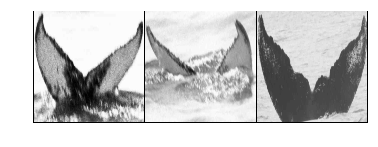

In [42]:
example_batch = next(ap_data_iter)

concatenated = torch.cat((example_batch[0],example_batch[1],example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))